## 导入必要的包

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## FNet层实现
tf.cast(inputs, tf.complex64): 将输入张量转换为复数类型，因为傅里叶变换需要复数输入<br>
tf.signal.fft2d: 对输入的最后两个维度(通常是序列长度和特征维度)执行2D快速傅里叶变换(FFT)<br>
tf.math.real: 取傅里叶变换结果的实部，丢弃虚部<br>

In [53]:
# FNet层实现
class FNetLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(FNetLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        # 对最后两个维度（序列长度和特征维度）做2D傅里叶变换
        fourier_features = tf.signal.fft2d(tf.cast(inputs, tf.complex64))
        # 只取实部（原始论文的做法）
        return tf.math.real(fourier_features)

## 参数定义
`VOCAB_SIZE`：定义词汇表的大小，别的单词视为未知词<br>
`MAX_SEQUENCE_LENGTH`：模型能处理的最大序列长度（以token为单位）。所有输入文本会被截断或填充到这个长度<br>
`EMBED_DIM`：词嵌入向量的维度，每个单词会被映射到一个128维的稠密向量<br>
`FF_DIM`：前馈网络（Feed-Forward Network）的隐藏层维度<br>
`NUM_LAYERS`：模型的层数（如Transformer的Encoder层数）

In [ ]:
# 模型参数
VOCAB_SIZE = 50000
MAX_SEQUENCE_LENGTH = 256
EMBED_DIM = 128
FF_DIM = 64
NUM_LAYERS = 2
NUM_HEADS = 8       # 注意力头数
lr = 1e-5
dropout_rate = 0.01
BATCH_SIZE = 16

## 加载数据集
x_train：训练集的文本数据（已转换为单词索引序列）  
y_train：训练集的标签（1=正面评价，0=负面评价）  
x_test：测试集的文本数据  
y_test：测试集的标签  
<br>
将训练集的变长序列填充/截断为统一长度,对于短于256的序列：在开头补零（如[0, 0, ..., 原始序列]）。对于长于256的序列：从开头截断（保留最后256个token）

In [55]:
# 加载IMDB数据集
# 加载数据
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)  
# 数据填充
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)  
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)

## 数据集样本展示
IMDB数据集中的输入样本采用整数序列的形式，每个整数对应词表中的唯一单词（如 1="the", 2="a", 3="movie"），通过imdb.get_word_index()可查看完整映射表，避免大小写、变形词等问题（如"Movie"和"movie"会被映射为相同整数），整数比字符串更节省内存，计算速度更快（GPU/TPU擅长处理数值张量）

In [56]:
# 输入样本（整数序列）
print(x_train[0])  # 输出：[1, 14, 22, 16, 43, 530, 973, ...]

# 对应标签
print(y_train[0])  # 输出：1（正面评价）

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     1    14    22    16    43   530   973  1622  1385    65
   458  4468    66  3941     4   173    36   256     5    25   100    43
   838   112    50   670 22665     9    35   480   284     5   150     4
   172   112   167 21631   336   385    39     4   172  4536  1111    17
   546    38    13   447     4   192    50    16     6   147  2025    19
    14    22     4  1920  4613   469     4    22    71    87    12    16
    43   530    38    76    15    13  1247     4    22    17   515    17
    12    16   626    18 19193     5    62   386    12     8   316     8
   106     5     4  2223  5244    16   480    66  3785    33     4   130
    12    16    38   619     5    25   124    51    36   135    48    25
  1415    33     6    22    12   215    28    77   

### 将数据集样本还原为文本：  
0: `PAD`：填充标记（用于统一序列长度）  
1: `START`：句子起始标记（早期版本使用，现在多数情况下无实际意义）  
2: `UNK`：未知词标记（词表中不存在的低频词）（只加载了使用频率前20000的单词）  

In [57]:
from tensorflow.keras.datasets import imdb

word_index = imdb.get_word_index()
reverse_index = {v+3: k for k, v in word_index.items()}
# 特殊标记
reverse_index[0] = "<PAD>"
reverse_index[1] = "<START>"
reverse_index[2] = "<UNK>"

decoded_review = ' '.join([reverse_index.get(i, '?') for i in x_train[0]])
print(decoded_review)

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's

## 创建FNet模型

In [58]:
def create_fnet_model():
    inputs = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
    
    # 1. 嵌入层（Token + Position）
    token_embedding = layers.Embedding(VOCAB_SIZE, EMBED_DIM)(inputs)
    position_ids = tf.range(start=0, limit=MAX_SEQUENCE_LENGTH, delta=1)
    position_embedding = layers.Embedding(MAX_SEQUENCE_LENGTH, EMBED_DIM)(position_ids)
    embeddings = token_embedding + position_embedding
    
    # 2. 添加dropout（原始论文在嵌入后立即使用）
    fnet_output = layers.Dropout(dropout_rate)(embeddings)

    # 3. FNet编码器层（重复NUM_LAYERS次）
    for _ in range(NUM_LAYERS):
        # 3.1 傅里叶变换子层
        residual = fnet_output
        fnet_output = FNetLayer()(fnet_output)  # 仅傅里叶变换，无混合注意力！
        fnet_output = layers.Dropout(dropout_rate)(fnet_output)
        fnet_output = layers.LayerNormalization(epsilon=1e-6)(residual + fnet_output)
        
        # 3.2 前馈网络子层（标准Transformer FFN）
        residual = fnet_output
        fnet_output = layers.Dense(FF_DIM, activation="relu")(fnet_output)  # 第一步：扩展维度 + 非线性激活
        fnet_output = layers.Dense(EMBED_DIM)(fnet_output)  # 第二步：投影回原始维度
        fnet_output = layers.Dropout(dropout_rate)(fnet_output)
        fnet_output = layers.LayerNormalization(epsilon=1e-6)(residual + fnet_output)
    
    # 4. 输出层（全局池化 + 分类头）
    pooled_output = layers.GlobalAveragePooling1D()(fnet_output)
    outputs = layers.Dense(1, activation="sigmoid")(pooled_output)
    
    return keras.Model(inputs=inputs, outputs=outputs)

In [59]:
def create_transformer_model():
    inputs = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
    
    # 嵌入层（词嵌入 + 位置编码）
    embedding_layer = layers.Embedding(VOCAB_SIZE, EMBED_DIM)(inputs)
    position_embedding = layers.Embedding(MAX_SEQUENCE_LENGTH, EMBED_DIM)(
        tf.range(start=0, limit=MAX_SEQUENCE_LENGTH, delta=1))
    embeddings = embedding_layer + position_embedding
    
    # 添加dropout防止过拟合
    x = layers.Dropout(dropout_rate)(embeddings)

    for _ in range(NUM_LAYERS):
        # 残差连接1：多头注意力
        residual = x
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.MultiHeadAttention(
            num_heads=NUM_HEADS,
            key_dim=EMBED_DIM // NUM_HEADS,
            dropout=dropout_rate
        )(x, x)  # 自注意力机制 (Q=K=V)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([residual, x])
        
        # 残差连接2：前馈网络
        residual = x
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Dense(FF_DIM, activation="relu")(x)  # 扩展维度
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(EMBED_DIM)(x)  # 投影回原始维度
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([residual, x])
    
    # 输出层
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    return keras.Model(inputs=inputs, outputs=outputs)

In [60]:
# 创建并编译模型
model = create_fnet_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()  # 输出层形状和参数统计

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 256, 128)     6400000     ['input_5[0][0]']                
                                                                                                  
 tf.__operators__.add_20 (TFOpL  (None, 256, 128)    0           ['embedding_8[0][0]']            
 ambda)                                                                                           
                                                                                                  
 dropout_20 (Dropout)           (None, 256, 128)     0           ['tf.__operators__.add_20[0

## 写入日志

In [61]:
import json
from keras.callbacks import Callback
from datetime import datetime

class JsonLogger(Callback):
    def __init__(self, filename, custom_params):
        super().__init__()
        self.filename = filename
        self.custom_params = custom_params
        # 在初始化时先写入一个空行
        with open(self.filename, 'a') as f:
            f.write('\n')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        # 添加时间戳（ISO 8601 格式）
        log_data = {
            "timestamp": datetime.now().isoformat(),  # 关键改动点
            "epoch": epoch,
            **logs,
            **self.custom_params
        }
        
        # 写入 JSON 文件（每行一个 JSON 对象）
        with open(self.filename, 'a') as f:
            f.write(json.dumps(log_data) + '\n')

# 使用自定义 JSON Logger
json_logger = JsonLogger(
    'training_log.json',
    custom_params={
        "batch_size": 16,
        "optimizer": "adam",
        "model_type": "FNet+Attention",
        "VOCAB_SIZE" : VOCAB_SIZE,
        "MAX_SEQUENCE_LENGTH" : MAX_SEQUENCE_LENGTH,
        "EMBED_DIM" : EMBED_DIM,
        "FF_DIM" : FF_DIM,
        "NUM_LAYERS" : NUM_LAYERS,
        "NUM_HEADS" : NUM_HEADS,
        "lr" : lr,
        "dropout_rate": dropout_rate,
        "batch_size" : BATCH_SIZE
    }
)

## 训练模型

In [62]:
from d2l import tensorflow as d2l  # 使用 TF 版本的 D2L

# 保持原有训练代码
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, validation_data=(x_test, y_test), epochs=10, callbacks=[json_logger])


Epoch 1/10


1563/1563 [==============================] - 36s 22ms/step - loss: 0.3790 - accuracy: 0.8256 - val_loss: 0.2905 - val_accuracy: 0.8784
Epoch 2/10
1563/1563 [==============================] - 34s 22ms/step - loss: 0.1523 - accuracy: 0.9420 - val_loss: 0.3519 - val_accuracy: 0.8636
Epoch 3/10
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0722 - accuracy: 0.9735 - val_loss: 0.4667 - val_accuracy: 0.8616
Epoch 4/10
1563/1563 [==============================] - 34s 21ms/step - loss: 0.0334 - accuracy: 0.9883 - val_loss: 0.6326 - val_accuracy: 0.8385
Epoch 5/10
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0217 - accuracy: 0.9920 - val_loss: 0.6886 - val_accuracy: 0.8604
Epoch 6/10
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0156 - accuracy: 0.9947 - val_loss: 0.7129 - val_accuracy: 0.8581
Epoch 7/10
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0121 - accuracy: 0.9957 - val_loss: 0.7699 - val_accura

测试集: 损失=0.8597, 准确率=0.8398


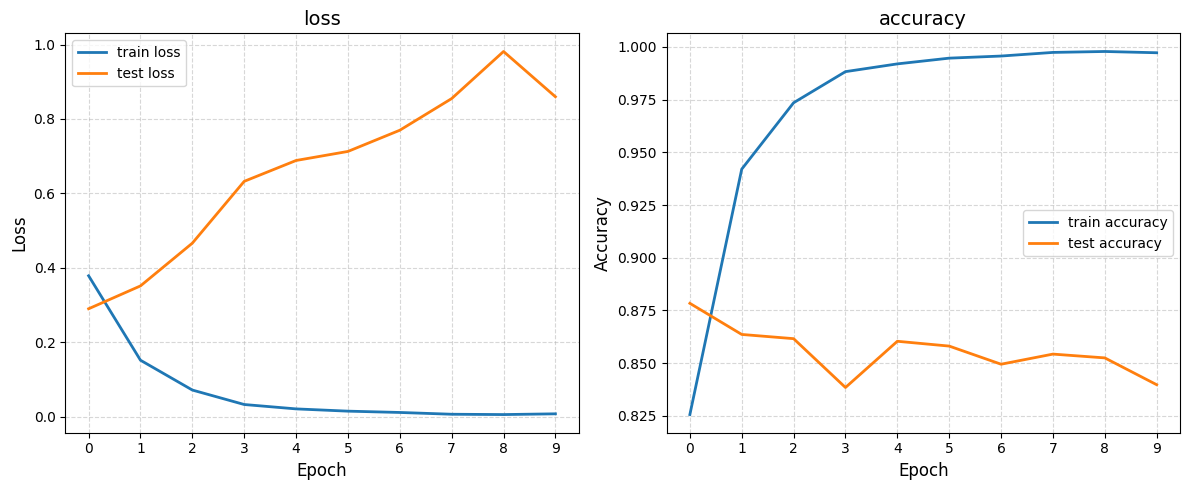

In [63]:
# 训练后验证效果
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"测试集: 损失={loss:.4f}, 准确率={acc:.4f}")

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_training_history(history, figsize=(12, 5)):
    """
    绘制训练历史的损失和准确率曲线（类似D2L风格）
    
    参数:
        history: Keras History 对象（model.fit()的返回值）
        figsize: 图像尺寸，默认(12, 5)
    """
    plt.figure(figsize=figsize)
    
    # 子图1：损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train loss', color='tab:blue', linestyle='-', linewidth=2)
    plt.plot(history.history['val_loss'], label='test loss', color='tab:orange', linestyle='-', linewidth=2)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # 仅显示整数epoch
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('loss', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 子图2：准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train accuracy', color='tab:blue', linestyle='-', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='test accuracy', color='tab:orange', linestyle='-', linewidth=2)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('accuracy', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# 绘制曲线（使用之前提供的绘图函数）
plot_training_history(history)  # 或 d2l 风格绘图